In [6]:
%run key_imports.py
%run nn_archi.py
%run utils.py

X_df = pd.read_csv("heston.csv")
feat_names = ['S/K', 'V','ttm', 'kappa', 'rho', 'vbar','vol_of_vol']
f_to_i = lambda x: feat_names.index(x)
Xs = X_df[feat_names].values
ys = X_df['digital_payoff']

print("BASELINE MSE: ", np.mean((ys - ys.mean()) ** 2))
print("BASELINE MAE: ", np.mean(np.abs(ys - ys.mean())))

all_res = []

BASELINE MSE:  0.2114706039428711
BASELINE MAE:  0.4229412078857422


In [10]:
HIDDEN_UNITS = 100
LAYERS = 2
dropout_ratio = 0.0
HIDDEN_ACT = 'softplus'
N_FEATS = len(feat_names)
OUTPUT_ACT = 'sigmoid'
DROPOUT_RATIO = 0.0
LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 10
BATCH_NORM = False

loss_fn = tf.keras.losses.MeanSquaredError()

METRICS = [tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()]
VAL_SPLIT = 0.2
CALLBACKS = [EarlyStopping(patience=5)]


opt = Adam(learning_rate = LR)
ffn = make_model(N_FEATS, 
                 HIDDEN_UNITS, 
                 LAYERS, 
                 DROPOUT_RATIO, 
                 HIDDEN_ACT, 
                 OUTPUT_ACT, 
                 BATCH_NORM)


ffn.compile(optimizer=opt, loss=loss_fn, metrics = METRICS)
history = ffn.fit(Xs, ys, 
                  epochs = EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_split = VAL_SPLIT,
                  shuffle=True,
                  callbacks=CALLBACKS)

Epoch 1/10
3277/3277 [==============================] - 5s 2ms/step - loss: 0.0629 - mean_absolute_error: 0.1315 - root_mean_squared_error: 0.2507 - val_loss: 0.0503 - val_mean_absolute_error: 0.1049 - val_root_mean_squared_error: 0.2242
Epoch 2/10
3277/3277 [==============================] - 6s 2ms/step - loss: 0.0551 - mean_absolute_error: 0.1088 - root_mean_squared_error: 0.2347 - val_loss: 0.0559 - val_mean_absolute_error: 0.1192 - val_root_mean_squared_error: 0.2364
Epoch 3/10
3277/3277 [==============================] - 6s 2ms/step - loss: 0.0547 - mean_absolute_error: 0.1101 - root_mean_squared_error: 0.2339 - val_loss: 0.0508 - val_mean_absolute_error: 0.1051 - val_root_mean_squared_error: 0.2253
Epoch 4/10
3277/3277 [==============================] - 6s 2ms/step - loss: 0.0542 - mean_absolute_error: 0.1089 - root_mean_squared_error: 0.2327 - val_loss: 0.0499 - val_mean_absolute_error: 0.1058 - val_root_mean_squared_error: 0.2233
Epoch 5/10
3277/3277 [==========================

<AxesSubplot:>

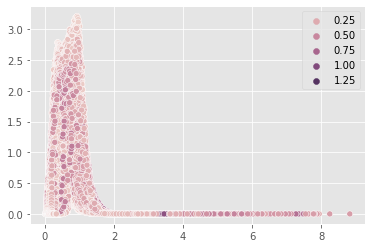

In [16]:
"""
Prediction Errors
"""
model = ffn
moneyness = np.exp(Xs[:, f_to_i("S/K")])
ttm = np.exp(Xs[:, f_to_i("ttm")])
true = X_df['digital_payoff']
intrinsic_val = np.maximum(moneyness - 1.0, 0)
preds = model.predict(Xs)
try:
    preds = preds.reshape(-1)
except:
    pass

"""
Compute all Gradients, Hessian
"""

X_tensor = tf.Variable(Xs)
with tf.GradientTape() as tape2:
    with tf.GradientTape() as tape:
        output = model(X_tensor)
        grads = tape.gradient(output, X_tensor)
    hessian1 = tape2.gradient(grads[:, f_to_i("S/K")], X_tensor)

grads = grads.numpy()
hessian_moneyness = hessian1.numpy()[:, [0]]

sns.scatterplot(x = Xs[:,0], y = grads[:,0], hue = Xs[:,1])